In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load data from metabolic panel csv
df = pd.read_csv('LSDS-8_Comprehensive_Metabolic_Panel_CMP_TRANSFORMED_all_astronauts.csv')

In [49]:
# check for missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
missing

total_bilirubin_value_milligram_per_deciliter                                        1
bun_to_creatinine_ratio_value                                                       22
bun_to_creatinine_ratio_range_min                                                    1
bun_to_creatinine_ratio_range_max                                                    1
egfr_african_american_range_max_milliliter_per_minute_per_1.73_meter_squared        28
egfr_non_african_american_range_max_milliliter_per_minute_per_1.73_meter_squared    28
dtype: int64

## Treating Missing Values by Imputing or Dropping

In [50]:
# bilirubin values can be skewed, so median is more robust than mean
df["total_bilirubin_value_milligram_per_deciliter"] = df["total_bilirubin_value_milligram_per_deciliter"].fillna(
    df["total_bilirubin_value_milligram_per_deciliter"].median()
)

In [51]:
# do we drop this? 22/28 are missing → impute with median for now
df["bun_to_creatinine_ratio_value"] = df["bun_to_creatinine_ratio_value"].fillna(
    df["bun_to_creatinine_ratio_value"].median()
)

# values can be skewed, so median is more robust
df["bun_to_creatinine_ratio_range_min"] = df["bun_to_creatinine_ratio_range_min"].fillna(
    df["bun_to_creatinine_ratio_range_min"].median()
)

df["bun_to_creatinine_ratio_range_max"] = df["bun_to_creatinine_ratio_range_max"].fillna(
    df["bun_to_creatinine_ratio_range_max"].median()
)

In [52]:
# drop empty columns
df = df.drop(
    columns=[
        "egfr_african_american_range_max_milliliter_per_minute_per_1.73_meter_squared",
        "egfr_non_african_american_range_max_milliliter_per_minute_per_1.73_meter_squared"
    ],
    errors="ignore"
)

In [53]:
# check again for missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
missing

Series([], dtype: int64)

In [ ]:
# save cleaned data
df.to_csv('all_astronauts_filled.csv', index=False)

In [55]:
# new feature: anion gap
df["anion_gap"] = df["sodium_value_millimol_per_liter"] - (
    df["chloride_value_millimol_per_liter"] + df["carbon_dioxide_value_millimol_per_liter"]
)

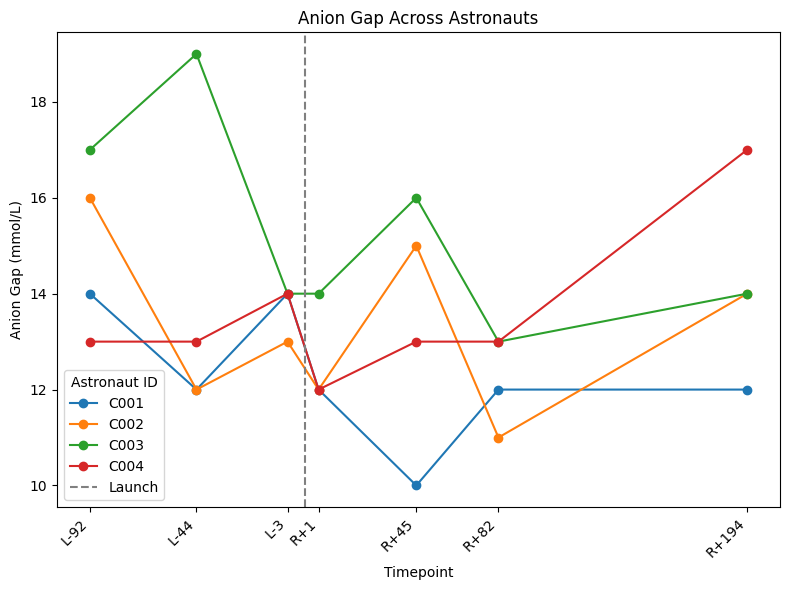

In [56]:
# plot Anion Gap over timepoints per astronaut

timepoint_mapping = {
    "L-92": -97,
    "L-44": -49,
    "L-3": -8,
    "R+1": 6,
    "R+45": 50,
    "R+82": 87,
    "R+194": 199
}

df["day"] = df["timepoint"].map(timepoint_mapping)

df_anion = df[["astronautID", "day", "timepoint", "anion_gap"]].dropna()
df_anion = df_anion.sort_values(by=["astronautID", "day"])

plt.figure(figsize=(8,6))
for astro_id, sub_df in df_anion.groupby("astronautID"):
    plt.plot(sub_df["day"], sub_df["anion_gap"], marker="o", label=astro_id)

plt.title("Anion Gap Across Astronauts")
plt.xlabel("Timepoint")
plt.ylabel("Anion Gap (mmol/L)")
plt.axvline(0, color="gray", linestyle="--", label="Launch")
plt.xticks(
    ticks=list(timepoint_mapping.values()),
    labels=list(timepoint_mapping.keys()),
    rotation=45,
    ha="right"
)
plt.legend(title="Astronaut ID")
plt.tight_layout()
plt.show()

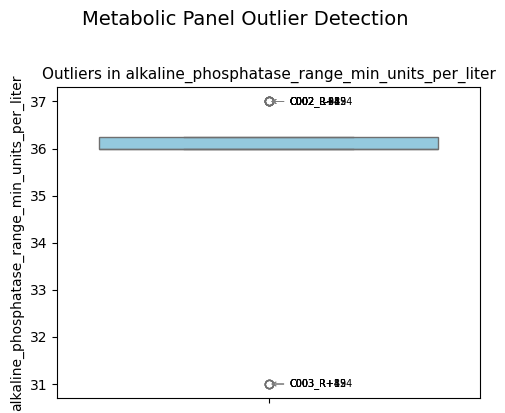

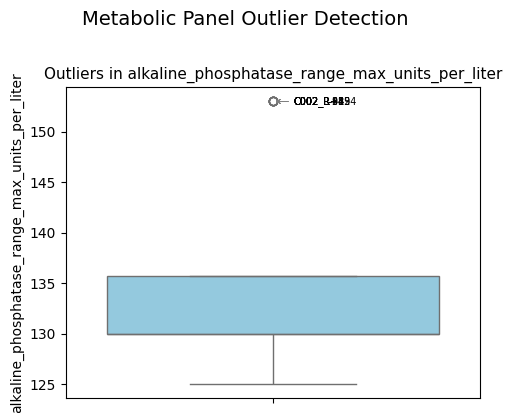

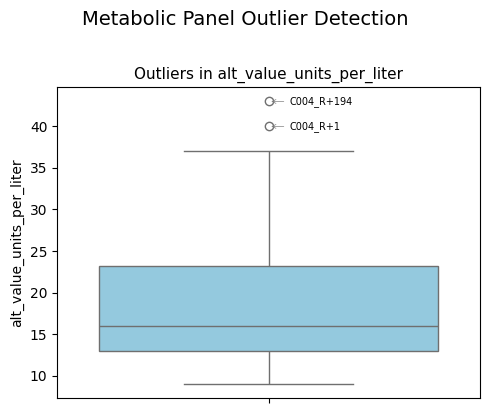

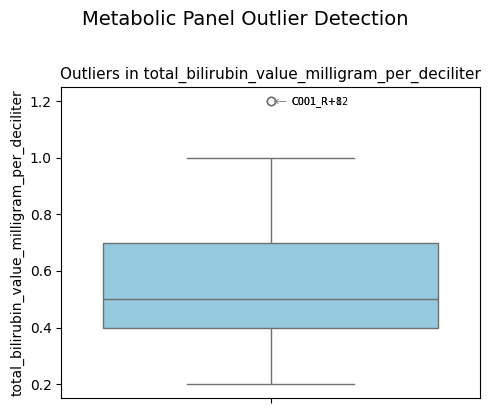

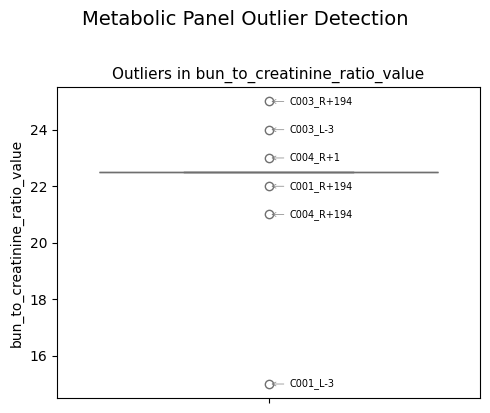

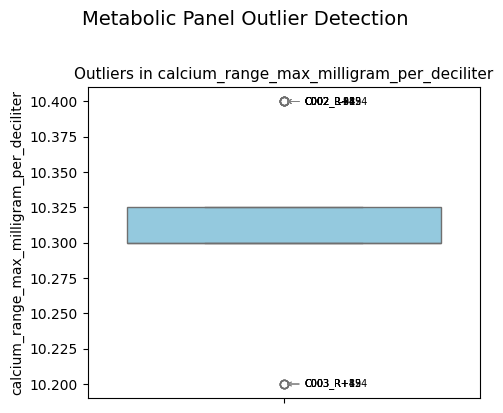

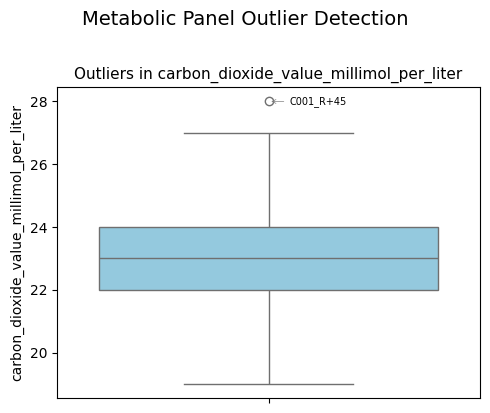

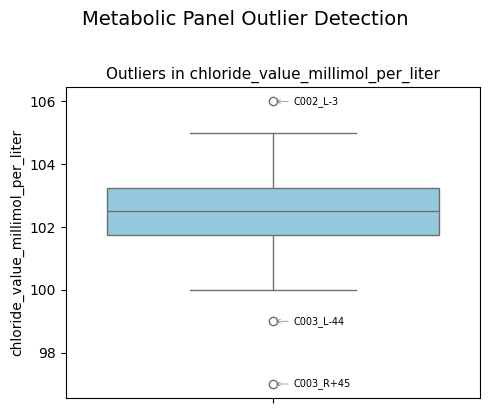

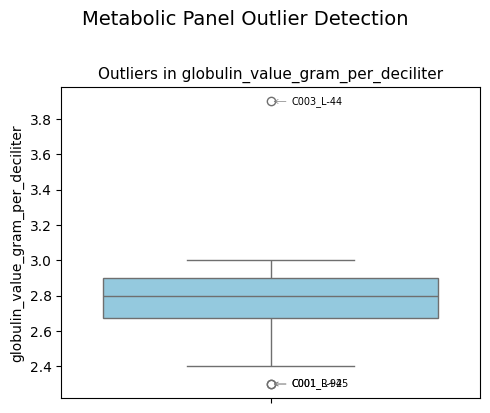

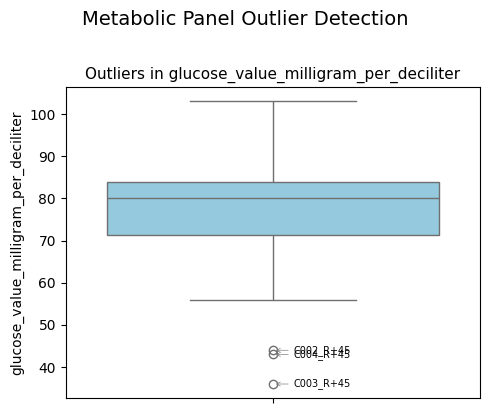

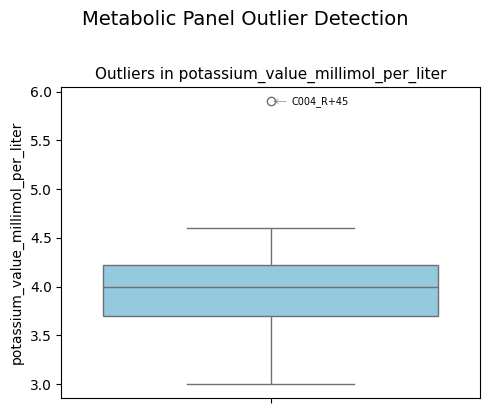

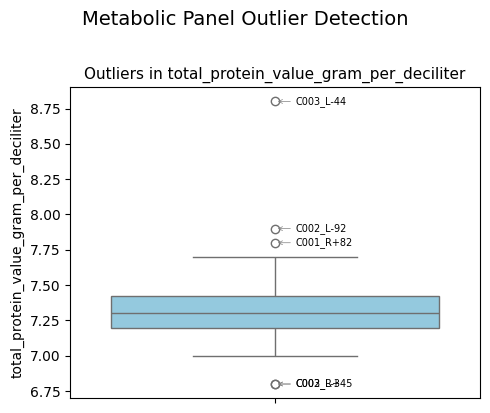

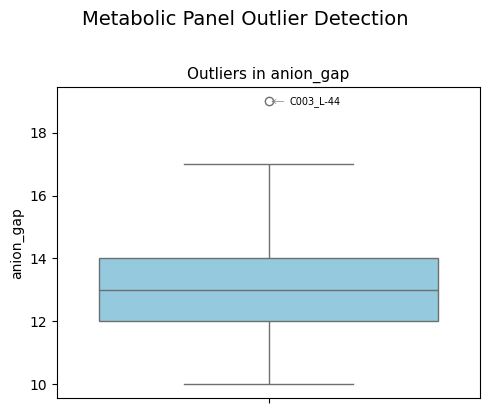

In [ ]:
# Select numeric columns only
numeric_cols = df.select_dtypes(include=["number"]).columns

# Loop through each numeric column and plot only if outliers exist
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df[(df[col] < lower) | (df[col] > upper)]

    if outliers.empty:
        continue  # skip this column if no outliers

    # ---- Plot boxplot ----
    plt.figure(figsize=(5, 4))
    ax = sns.boxplot(y=df[col], color="skyblue")

    # Annotate outliers: label horizontally next to dot
    for idx, val in outliers[col].items():
        label = f"{df.loc[idx, 'astronautID']}_{df.loc[idx, 'timepoint']}"
        ax.annotate(
            label,
            xy=(0, val), xycoords="data",          # point location
            xytext=(15, 0), textcoords="offset points",  # shift right by 15 px
            ha="left", va="center", fontsize=7,
            arrowprops=dict(arrowstyle="->", lw=0.5, color="gray")
        )

    plt.title(f"Outliers in {col}", fontsize=11)
    plt.suptitle("Metabolic Panel Outlier Detection", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
